In [1]:
import csv
import os, sys
from IPython.display import display
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#%matplotlib inline
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook

/home/ahuertas/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [48]:
mode = "all_pos"
#mode = "4_pos"

#mode = "JAM_all_pos"
#mode = "JAM_always_attack"

attack = "FLO"
#attack = "JAM"

In [3]:
#csv_filenames = ["original_CNN.csv", "port_scanning.csv", "selective_forwarding.csv", "flooding.csv", "jamming.csv", 
#                 "spoofing.csv", "sybil.csv"]

csv_filenames = ["original.csv", "Flooding.csv"]

#attack_names = ["SCA", "FOR", "FLO", "JAM", "SPO", "SYB"]

attack_names = ["JAM"]

N_NEURONS_FIRST_LAYER = 200
#N_POSITIONS_MAZE = 34
N_POSITIONS_MAZE = 27
#N_TOTAL_NEURONS_ALL_POSITIONS = 6800
#N_EXECUTIONS = 50
N_EXECUTIONS = 10
N_EXECUTIONS_PER_POSITION = N_POSITIONS_MAZE*N_EXECUTIONS

#list_stimValues_activation = ['0.25', '0.5', '0.75', '1.0']
list_stimValues_activation = ['0.15', '0.3', '0.6', '0.9']
list_stimValues_inhibition = ['-1.0']

In [4]:
if mode == "all_pos":
    dir_data = "/data/CNN/output/FLO_all_positions"
elif mode == "4_pos":
    dir_data = "/data/CNN/output/FLO_4_positions"
elif mode == "JAM_all_pos":
    dir_data = "/data/CNN/output/JAM_all_positions"
elif mode == "JAM_always_attack":
    dir_data = "/data/CNN/output/JAM_always_attack/10exec_1-20n"

In [5]:
dir_data

'/data/ahuertas/CNN/output/FLO_all_positions'

In [6]:
df = pd.DataFrame()

for filename in csv_filenames:
    filepath = os.path.join(dir_data, filename)
    
    if filename in ["original.csv"]:
        if attack == "JAM":
            df = pd.concat([df, pd.read_csv(filepath, delimiter=";", usecols=["attack", "n_nodes", "positions_attacked", "solution", "n_steps", "n_exec"])], sort=True)
        else:
            df = pd.concat([df, pd.read_csv(filepath, delimiter=";", usecols=["attack", "n_nodes", "X", "Y", "position","solution", "stim_value", "n_steps", "n_exec"])], sort=True)
        
    if filename in ["Flooding.csv"]:
        df = pd.concat([df, pd.read_csv(filepath, delimiter=";", usecols=["attack", "n_nodes", "X", "Y", "position","solution", "stim_value", "n_steps", "n_exec"])], sort=True)
    
    if filename in ["Jamming.csv"]:
        df = pd.concat([df, pd.read_csv(filepath, delimiter=";", usecols=["attack", "n_nodes", "positions_attacked", "solution", "n_steps", "n_exec"])], sort=True)
        df.reset_index(inplace=True, drop=True)
        
# Fill NaN cells with zero value
#df = df.fillna(0)

# Create column "coordinate" appending X and Y values
if attack not in ["JAM"]:
    df["coordinate"] = df["X"].map(str) + ","+ df["Y"].map(str)

# quickfix for old csvs where the bug with the number of steps was not corrected
if mode == "all_pos":
    df["n_steps"] = df["n_steps"]+df["position"]-1

df.solution = df.solution.replace(False, 0)
df.solution = df.solution.replace(True, 1)

In [7]:
#df.positions_attacked

In [8]:
if mode == "4_pos":
    # fix results generated with increments of 5, instead of 10 (Brian)
    selected_nodes = [0] # keep originalCNN rows

    for nodes in range(5,110,10):
        selected_nodes.append(nodes)

    df = df[df.n_nodes.isin(selected_nodes)].copy()

In [9]:
if mode == "4_pos":
    # duplicate origina_CNN data for each value of n_nodes
    df_spontaneous = df[df.attack == "original_CNN"].copy()

    for nodes in range(5,110,10):
        df_spontaneous["n_nodes"] = nodes
        df = df.append(df_spontaneous)

## ANALYSIS

In [10]:
plt.rcParams.update({'font.family': 'monospace'})
sns.set(style="whitegrid",font_scale=2.5, rc={'figure.figsize':(40,20)})
plt.rcParams['axes.edgecolor'] = "black" #set the value globally

label_size = 40
ticks_size = 35
legend_size = 30
line_size = 10

### FLO

In [11]:
# df for all positions (FLO and original), n_nodes = [0,5,35,55,75,105], stim_value = [0, 0.6]
df_FLO_all_pos = df[(df.n_nodes.isin([0,5,35,55,75,105])) & (df.stim_value.isin([0, 0.6]))].copy()

In [12]:
stim_value = [0.6]

In [13]:
############# FLO - ROC CALCULATION. 24-27 aggregated #############

In [14]:
list_nodes = df_FLO_all_pos.n_nodes.unique().tolist()[1:]

In [15]:
df_FLO_all_pos_24_27 = df_FLO_all_pos[df_FLO_all_pos.position >= 24].copy()
df_FLO_all_pos_24_27["FPR"] = -1
df_FLO_all_pos_24_27["TPR"] = 1

In [16]:
# Calculate FPR values
for i in range(0, df_FLO_all_pos_24_27.solution.count()):    
    df_FLO_all_pos_24_27.iloc[i, df_FLO_all_pos_24_27.columns.get_loc('FPR')] = df_FLO_all_pos_24_27.iloc[i, df_FLO_all_pos_24_27.columns.get_loc('n_steps')] - 26

In [17]:
# Obtain maximum value within FPR column
#max_value = df_FLO_all_pos_24_27.FPR.max()
max_value = df_FLO_all_pos_24_27[(df_FLO_all_pos_24_27.solution == 1)].n_steps.max()
max_value

30

In [18]:
# Normalize FPR values
for i in range(0, df_FLO_all_pos_24_27.solution.count()):
    FPR_value = df_FLO_all_pos_24_27.iloc[i, df_FLO_all_pos_24_27.columns.get_loc('FPR')]
    df_FLO_all_pos_24_27.iloc[i, df_FLO_all_pos_24_27.columns.get_loc('FPR')] = (FPR_value-0)/(max_value-0)

In [19]:
# all 24-27 positions grouped
df_FLO_nodes = df_FLO_all_pos_24_27.groupby(["n_nodes"]).agg({'FPR':'mean', 'TPR': 'mean'})
df_FLO_nodes.reset_index(inplace=True, drop=False)

In [20]:
# individual positions
df_FLO_positions = df_FLO_all_pos_24_27.groupby(["n_nodes", "position"]).agg({'FPR':'mean', 'TPR': 'mean'})
df_FLO_positions.reset_index(inplace=True, drop=False)

In [21]:
df_FLO_nodes

,n_nodes,FPR,TPR
0,0,0.016667,1
1,5,0.016667,1
2,35,0.600833,1
3,55,0.261667,1
4,75,0.345000,1
5,105,0.839167,1


In [22]:
# Add (0,0) and (1,1) dots

for nodes in list_nodes:
    df_FLO_nodes = df_FLO_nodes.append({'n_nodes': nodes, "FPR": 0, "TPR": 0}, ignore_index=True)
    df_FLO_nodes = df_FLO_nodes.append({'n_nodes': nodes, "FPR": 1, "TPR": 1}, ignore_index=True)

for nodes in list_nodes:
    for position in range(24, 28):
        df_FLO_positions = df_FLO_positions.append({'n_nodes': nodes, "position": position, "FPR": 0, "TPR": 0}, ignore_index=True)
        df_FLO_positions = df_FLO_positions.append({'n_nodes': nodes, "position": position, "FPR": 1, "TPR": 1}, ignore_index=True)

In [23]:
df_FLO_nodes = df_FLO_nodes.sort_values(["n_nodes", "TPR"], ascending=True)
df_FLO_positions = df_FLO_positions.sort_values(["n_nodes", "TPR"], ascending=True)

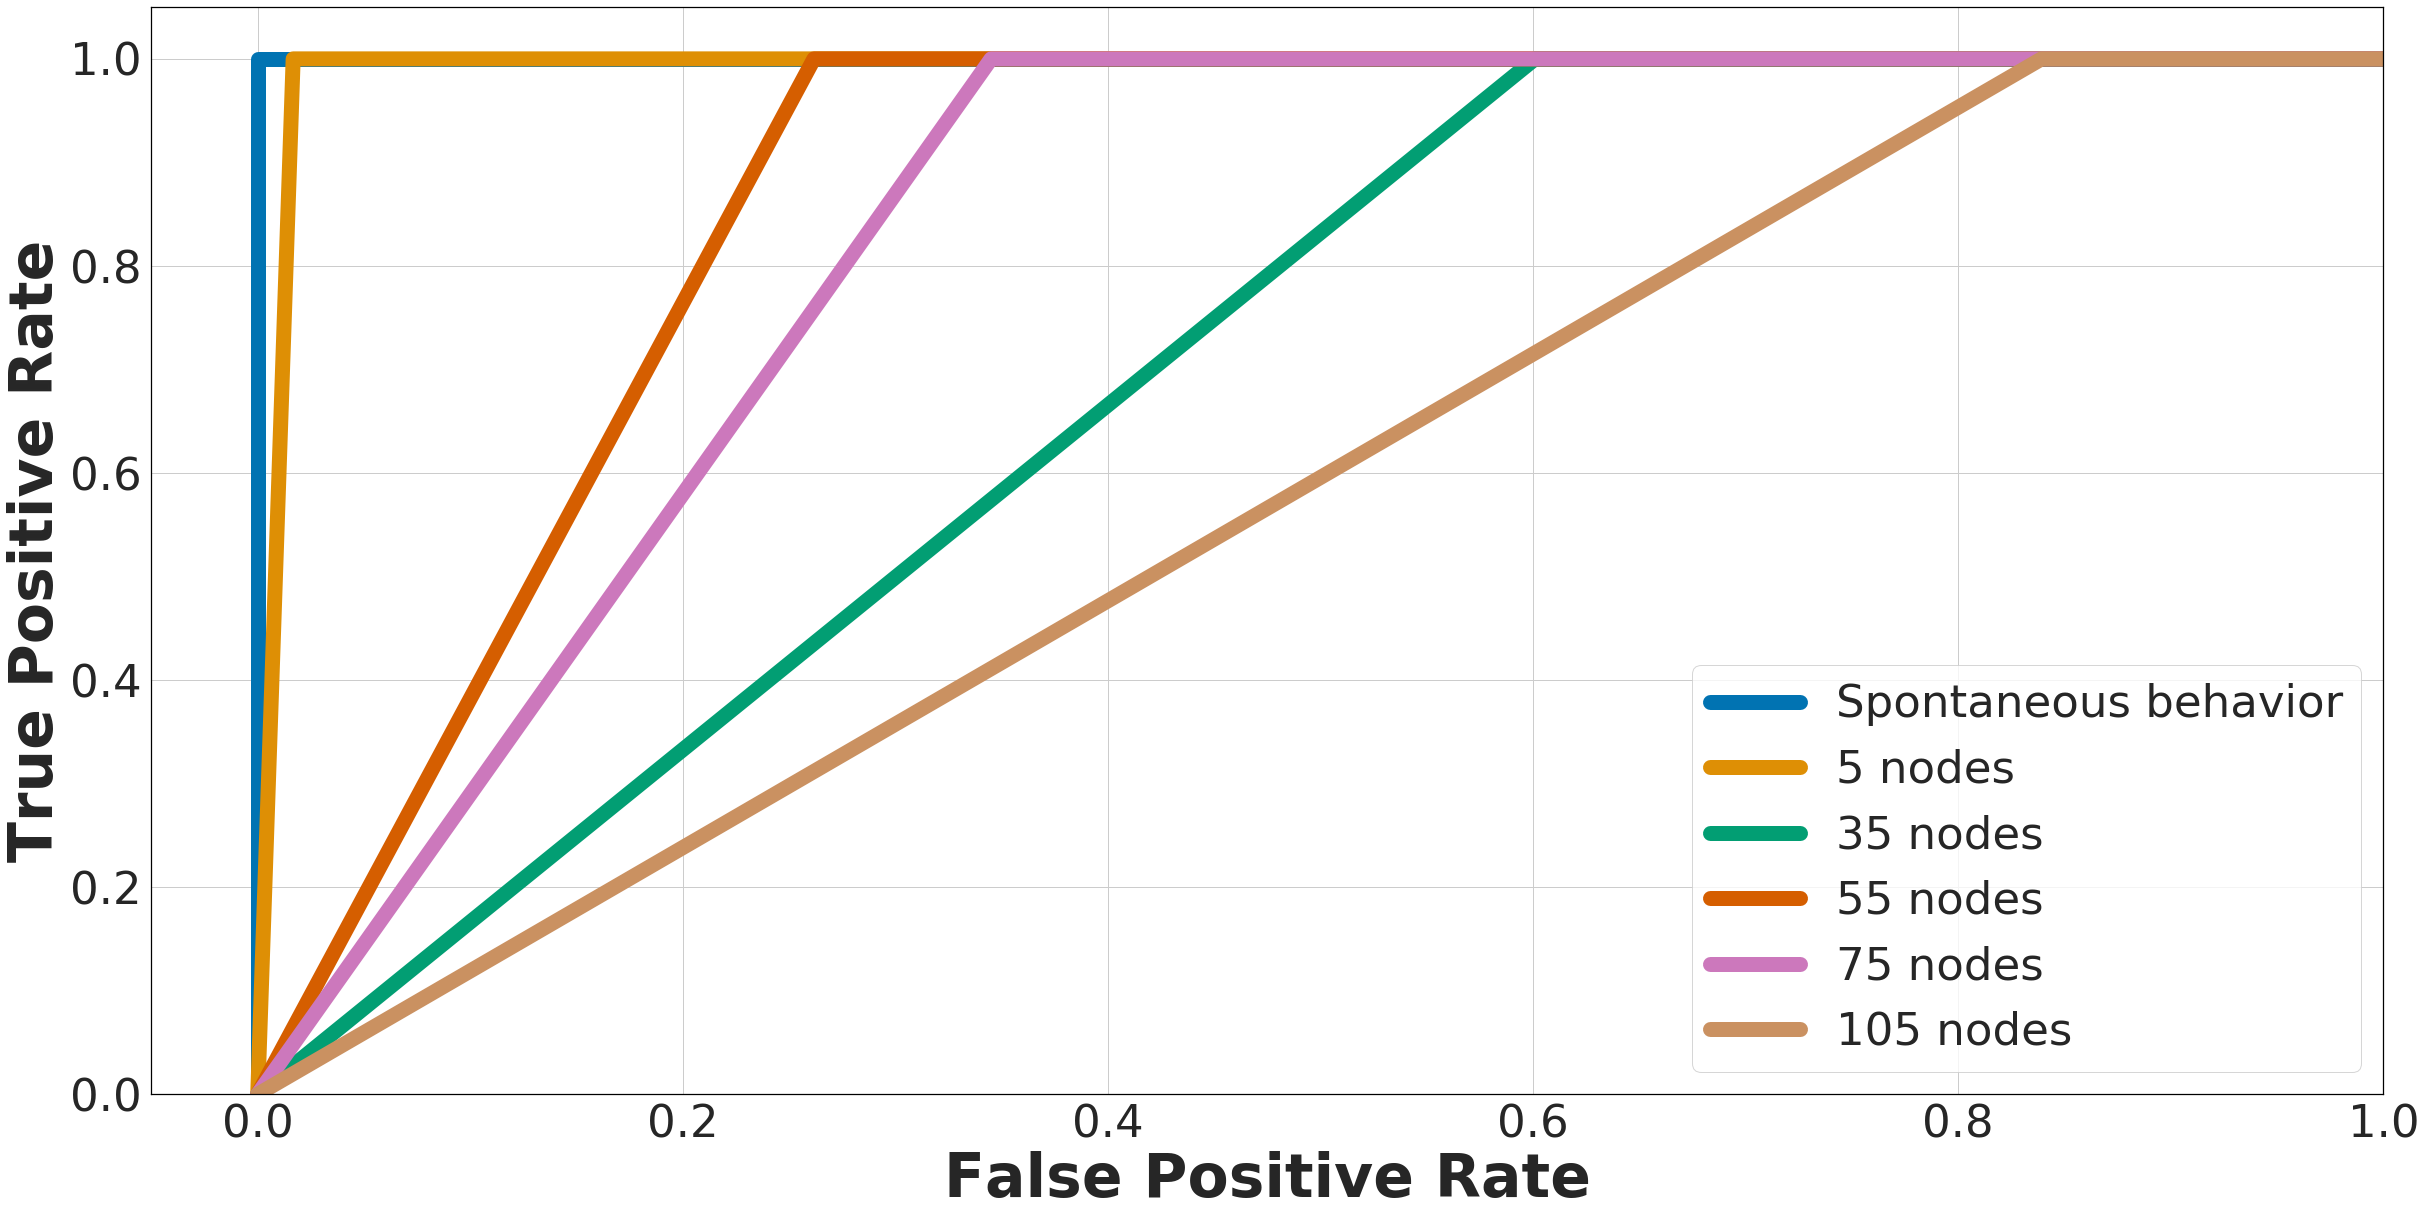

In [32]:
label_size = 60
ticks_size = 45
legend_size = 45
line_size = 15

# Only nodes, with aggregated positions
fpr_spontaneous = [0,0,1]
tpr_spontaneous = [0,1,1]

plt.figure()
lw = line_size
plt.plot(fpr_spontaneous, tpr_spontaneous, color='#0173B2',
         lw=lw, label='Spontaneous behavior')

plt.plot(df_FLO_nodes[df_FLO_nodes.n_nodes == 5].FPR.tolist(), df_FLO_nodes[df_FLO_nodes.n_nodes == 5].TPR.tolist(), color='#DE8F05',
         lw=lw, label='5 nodes')

plt.plot(df_FLO_nodes[df_FLO_nodes.n_nodes == 35].FPR.tolist(), df_FLO_nodes[df_FLO_nodes.n_nodes == 35].TPR.tolist(), color='#029E73',
         lw=lw, label='35 nodes')

plt.plot(df_FLO_nodes[df_FLO_nodes.n_nodes == 55].FPR.tolist(), df_FLO_nodes[df_FLO_nodes.n_nodes == 55].TPR.tolist(), color='#D55E00',
         lw=lw, label='55 nodes')

plt.plot(df_FLO_nodes[df_FLO_nodes.n_nodes == 75].FPR.tolist(), df_FLO_nodes[df_FLO_nodes.n_nodes == 75].TPR.tolist(), color='#CC78BC',
         lw=lw, label='75 nodes')

plt.plot(df_FLO_nodes[df_FLO_nodes.n_nodes == 105].FPR.tolist(), df_FLO_nodes[df_FLO_nodes.n_nodes == 105].TPR.tolist(), color='#CA9161',
         lw=lw, label='105 nodes')

#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=label_size, fontweight='bold')
plt.ylabel('True Positive Rate', size=label_size, fontweight='bold')
plt.legend(loc="lower right", fontsize=legend_size)


plt.gca().tick_params(labelsize=ticks_size)


#plt.title("ROC curve for positions 24-27")
#plt.show()
plt.savefig("ROC_FLO_24-27.pdf", bbox_inches='tight')

In [ ]:
# Nodes for a particular position
fixed_pos = 25

fpr_spontaneous = [0,0,1]
tpr_spontaneous = [0,1,1]

plt.figure()
lw = 4
plt.plot(fpr_spontaneous, tpr_spontaneous, color='darkorange',
         lw=lw, label='Spontaneous behavior')

plt.plot(df_FLO_positions[(df_FLO_positions.n_nodes == 5) & (df_FLO_positions.position == fixed_pos)].FPR.tolist(), 
        df_FLO_positions[(df_FLO_positions.n_nodes == 5) & (df_FLO_positions.position == fixed_pos)].TPR.tolist(), 
         color='red', lw=lw, label='5 nodes')

plt.plot(df_FLO_positions[(df_FLO_positions.n_nodes == 35) & (df_FLO_positions.position == fixed_pos)].FPR.tolist(), 
         df_FLO_positions[(df_FLO_positions.n_nodes == 35) & (df_FLO_positions.position == fixed_pos)].TPR.tolist(), 
         color='blue', lw=lw, label='35 nodes')

plt.plot(df_FLO_positions[(df_FLO_positions.n_nodes == 55) & (df_FLO_positions.position == fixed_pos)].FPR.tolist(), 
         df_FLO_positions[(df_FLO_positions.n_nodes == 55) & (df_FLO_positions.position == fixed_pos)].TPR.tolist(), 
         color='pink', lw=lw, label='55 nodes')

plt.plot(df_FLO_positions[(df_FLO_positions.n_nodes == 75) & (df_FLO_positions.position == fixed_pos)].FPR.tolist(), 
         df_FLO_positions[(df_FLO_positions.n_nodes == 75) & (df_FLO_positions.position == fixed_pos)].TPR.tolist(), 
         color='green', lw=lw, label='75 nodes')

plt.plot(df_FLO_positions[(df_FLO_positions.n_nodes == 105) & (df_FLO_positions.position == fixed_pos)].FPR.tolist(), 
         df_FLO_positions[(df_FLO_positions.n_nodes == 105) & (df_FLO_positions.position == fixed_pos)].TPR.tolist(), 
         color='yellow', lw=lw, label='105 nodes')

#plt.plot([0, 1], [0, 1], color='navy', lw=2)


plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve for positions 1-23 (position " + str(fixed_pos) + ")")
plt.show()

In [26]:
############# FLO - ROC CALCULATION. 1-23 #############

In [33]:
list_nodes = df_FLO_all_pos.n_nodes.unique().tolist()[1:]

In [34]:
df_FLO_all_pos_1_23 = df_FLO_all_pos[df_FLO_all_pos.position < 24].copy()
df_FLO_all_pos_1_23["FPR"] = -1
df_FLO_all_pos_1_23["TPR"] = -1

In [35]:
df_FLO_all_pos_1_23

,X,Y,attack,n_exec,n_nodes,n_steps,position,solution,stim_value,coordinate,FPR,TPR
0,0,0,original_CNN,0,0,26,1,1.0,0.0,"0,0",-1,-1
1,1,0,original_CNN,0,0,26,2,1.0,0.0,"1,0",-1,-1
2,1,1,original_CNN,0,0,26,3,1.0,0.0,"1,1",-1,-1
3,1,2,original_CNN,0,0,26,4,1.0,0.0,"1,2",-1,-1
4,0,2,original_CNN,0,0,26,5,1.0,0.0,"0,2",-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
22505,5,3,FLO,5,105,123,23,0.0,0.6,"5,3",-1,-1
22506,5,3,FLO,6,105,122,23,0.0,0.6,"5,3",-1,-1
22507,5,3,FLO,7,105,26,23,1.0,0.6,"5,3",-1,-1
22508,5,3,FLO,8,105,26,23,1.0,0.6,"5,3",-1,-1


In [36]:
# Calculate FPR values
for i in range(0, df_FLO_all_pos_1_23.solution.count()):
    if df_FLO_all_pos_1_23.iloc[i].solution == 1:
        df_FLO_all_pos_1_23.iloc[i, df_FLO_all_pos_1_23.columns.get_loc('FPR')] = df_FLO_all_pos_1_23.iloc[i, df_FLO_all_pos_1_23.columns.get_loc('n_steps')] - 26
    else:
        df_FLO_all_pos_1_23.iloc[i, df_FLO_all_pos_1_23.columns.get_loc('FPR')] = df_FLO_all_pos_1_23.iloc[i, df_FLO_all_pos_1_23.columns.get_loc('n_steps')] - df_FLO_all_pos_1_23.iloc[i, df_FLO_all_pos_1_23.columns.get_loc('position')] + 1
       
        
# Calculate TPR values
for i in range(0, df_FLO_all_pos_1_23.solution.count()):
    if df_FLO_all_pos_1_23.iloc[i].solution == 1:
        df_FLO_all_pos_1_23.iloc[i, df_FLO_all_pos_1_23.columns.get_loc('TPR')] = 26
    else:
        df_FLO_all_pos_1_23.iloc[i, df_FLO_all_pos_1_23.columns.get_loc('TPR')] = df_FLO_all_pos_1_23.iloc[i, df_FLO_all_pos_1_23.columns.get_loc('position')]-1

In [37]:
# Obtain maximum value within FPR column
max_value = df_FLO_all_pos_1_23.FPR.max()

In [38]:
# Normalize FPR values
for i in range(0, df_FLO_all_pos_1_23.solution.count()):
    FPR_value = df_FLO_all_pos_1_23.iloc[i, df_FLO_all_pos_1_23.columns.get_loc('FPR')]
    TPR_value = df_FLO_all_pos_1_23.iloc[i, df_FLO_all_pos_1_23.columns.get_loc('TPR')]
    
    df_FLO_all_pos_1_23.iloc[i, df_FLO_all_pos_1_23.columns.get_loc('FPR')] = (FPR_value-0)/(max_value-0)
    df_FLO_all_pos_1_23.iloc[i, df_FLO_all_pos_1_23.columns.get_loc('TPR')] = (TPR_value-0)/(26-0)

In [39]:
# all 1-23 positions grouped
df_FLO_nodes = df_FLO_all_pos_1_23.groupby(["n_nodes"]).agg({'FPR':'mean', 'TPR': 'mean'})
df_FLO_nodes.reset_index(inplace=True, drop=False)

In [40]:
df_FLO_nodes

,n_nodes,FPR,TPR
0,0,0.000000,1.000000
1,5,0.295080,0.765719
2,35,0.730931,0.470569
3,55,0.785202,0.457860
4,75,0.800648,0.450502
5,105,0.782914,0.449833


In [41]:
# individual positions
df_FLO_positions = df_FLO_all_pos_1_23.groupby(["n_nodes", "position"]).agg({'FPR':'mean', 'TPR': 'mean'})
df_FLO_positions.reset_index(inplace=True, drop=False)

In [42]:
df_FLO_positions

,n_nodes,position,FPR,TPR
0,0,1,0.000000,1.000000
1,0,2,0.000000,1.000000
2,0,3,0.000000,1.000000
3,0,4,0.000000,1.000000
4,0,5,0.000000,1.000000
...,...,...,...,...
133,105,19,0.695614,0.753846
134,105,20,0.607895,0.811538
135,105,21,0.435965,0.884615
136,105,22,0.434211,0.903846


In [43]:
# Add (0,0) and (1,1) dots

for nodes in list_nodes:
    df_FLO_nodes = df_FLO_nodes.append({'n_nodes': nodes, "FPR": 0, "TPR": 0}, ignore_index=True)
    df_FLO_nodes = df_FLO_nodes.append({'n_nodes': nodes, "FPR": 1, "TPR": 1}, ignore_index=True)

for nodes in list_nodes:
    for position in range(1, 24):
        df_FLO_positions = df_FLO_positions.append({'n_nodes': nodes, "position": position, "FPR": 0, "TPR": 0}, ignore_index=True)
        df_FLO_positions = df_FLO_positions.append({'n_nodes': nodes, "position": position, "FPR": 1, "TPR": 1}, ignore_index=True)

In [44]:
df_FLO_nodes = df_FLO_nodes.sort_values(["n_nodes", "TPR"], ascending=True)
df_FLO_positions = df_FLO_positions.sort_values(["n_nodes", "TPR"], ascending=True)

In [45]:
df_FLO_nodes

,n_nodes,FPR,TPR
0,0,0.000000,1.000000
6,5,0.000000,0.000000
1,5,0.295080,0.765719
7,5,1.000000,1.000000
8,35,0.000000,0.000000
2,35,0.730931,0.470569
9,35,1.000000,1.000000
10,55,0.000000,0.000000
3,55,0.785202,0.457860
11,55,1.000000,1.000000


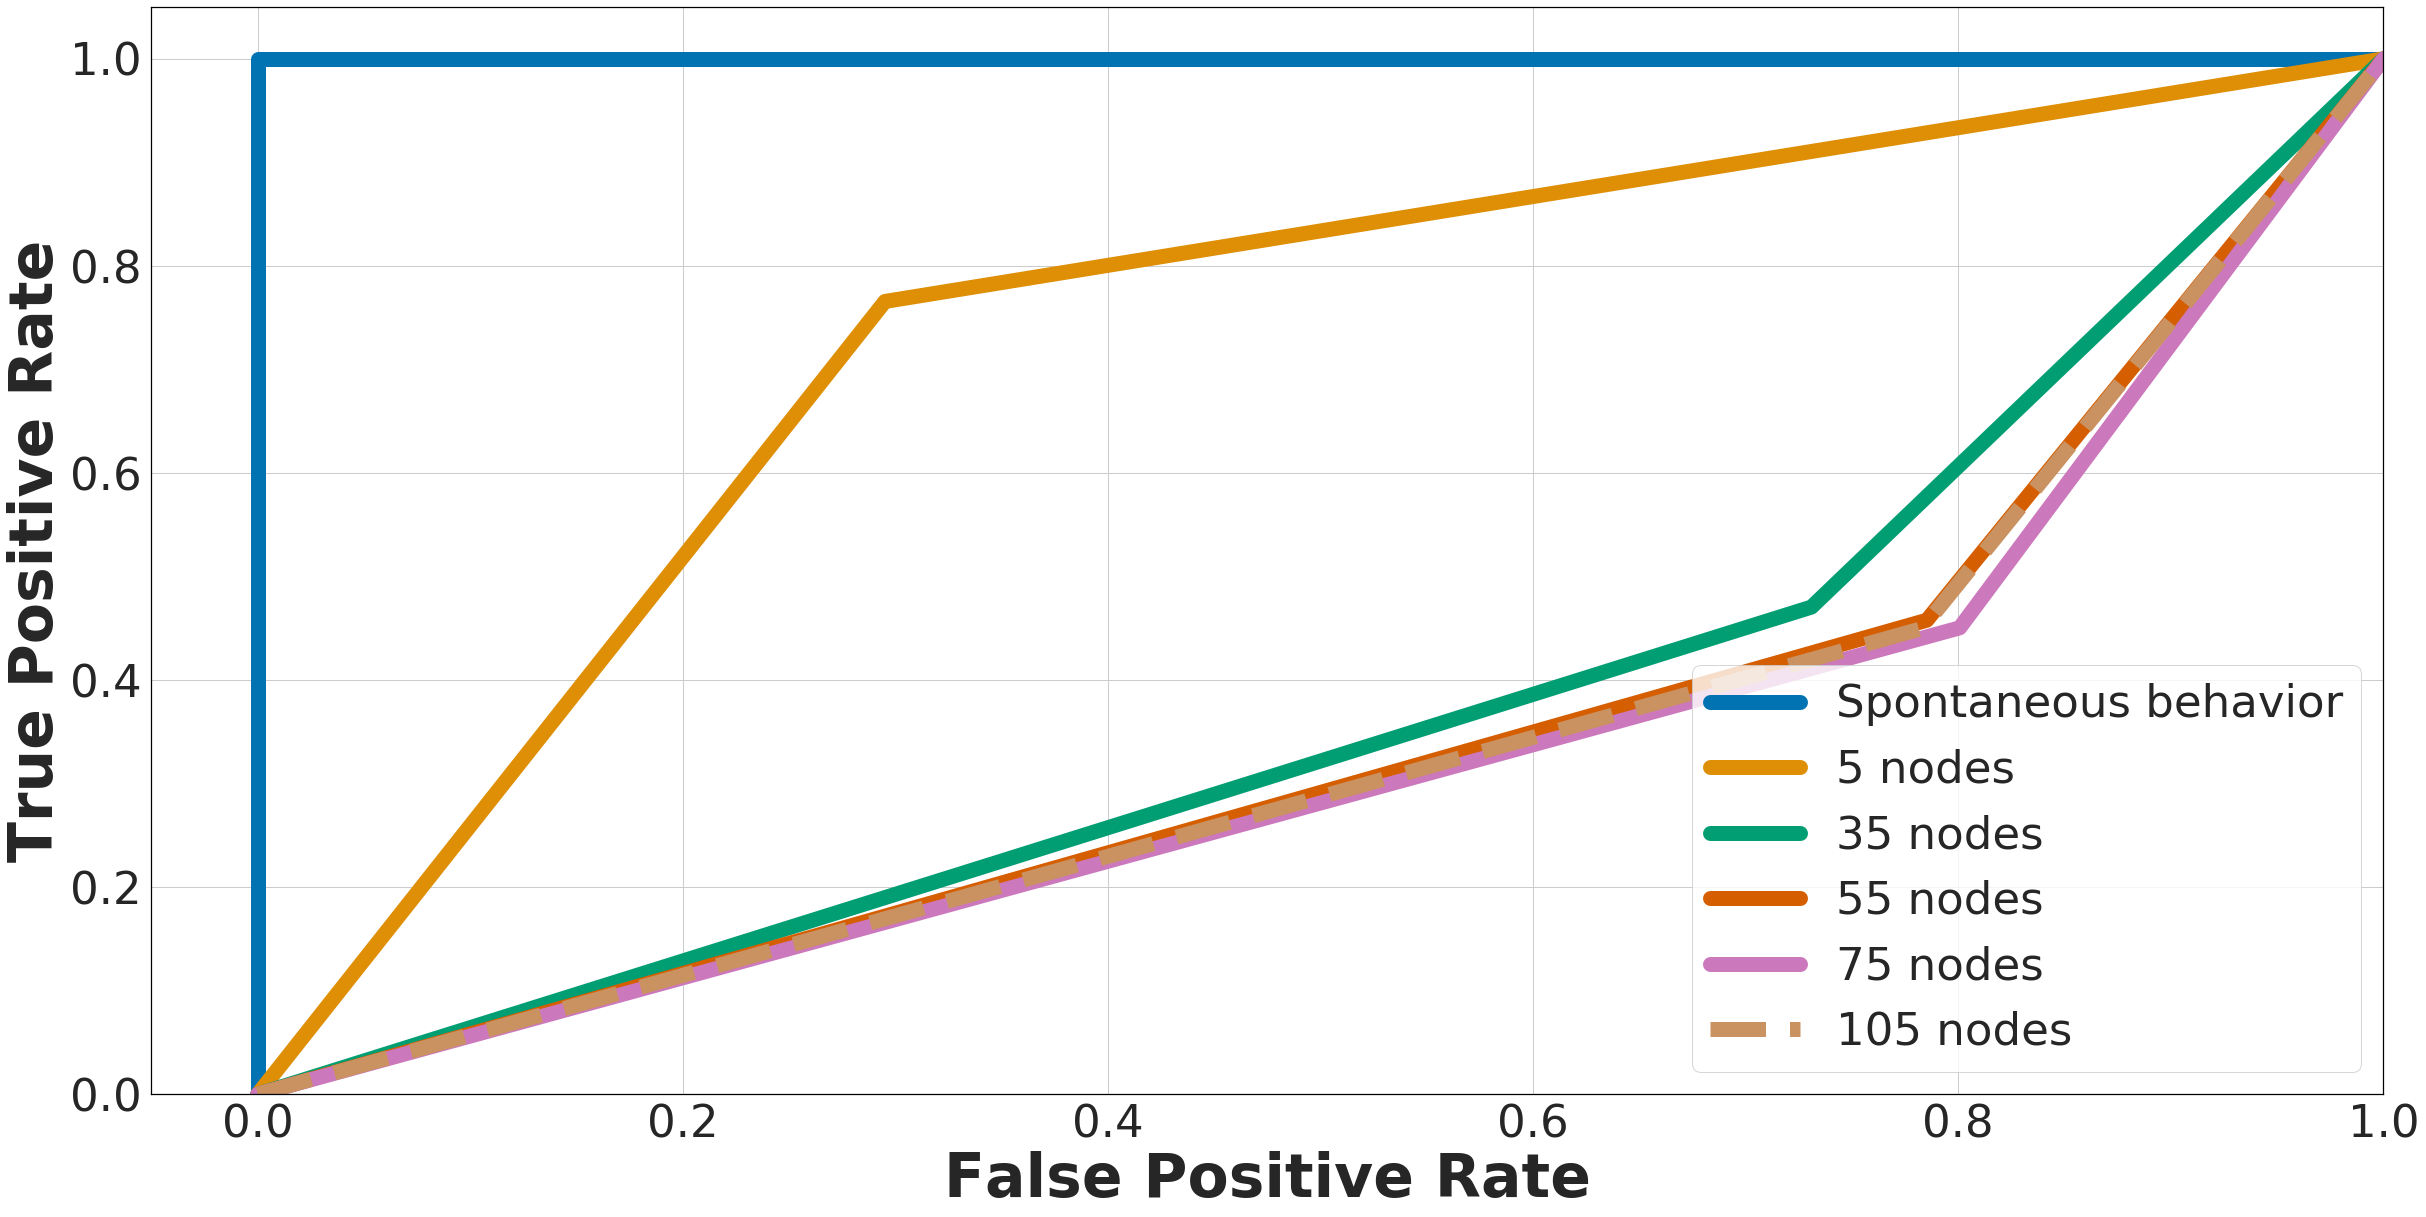

In [47]:
# Only nodes, with aggregated positions
fpr_spontaneous = [0,0,1]
tpr_spontaneous = [0,1,1]

plt.figure()
lw = line_size
plt.plot(fpr_spontaneous, tpr_spontaneous, color='#0173B2',
         lw=lw, label='Spontaneous behavior')

plt.plot(df_FLO_nodes[df_FLO_nodes.n_nodes == 5].FPR.tolist(), df_FLO_nodes[df_FLO_nodes.n_nodes == 5].TPR.tolist(), color='#DE8F05',
         lw=lw, label='5 nodes')

plt.plot(df_FLO_nodes[df_FLO_nodes.n_nodes == 35].FPR.tolist(), df_FLO_nodes[df_FLO_nodes.n_nodes == 35].TPR.tolist(), color='#029E73',
         lw=lw, label='35 nodes')

plt.plot(df_FLO_nodes[df_FLO_nodes.n_nodes == 55].FPR.tolist(), df_FLO_nodes[df_FLO_nodes.n_nodes == 55].TPR.tolist(), color='#D55E00',
         lw=lw, label='55 nodes')

plt.plot(df_FLO_nodes[df_FLO_nodes.n_nodes == 75].FPR.tolist(), df_FLO_nodes[df_FLO_nodes.n_nodes == 75].TPR.tolist(), color='#CC78BC',
         lw=lw, label='75 nodes')

plt.plot(df_FLO_nodes[df_FLO_nodes.n_nodes == 105].FPR.tolist(), df_FLO_nodes[df_FLO_nodes.n_nodes == 105].TPR.tolist(), color='#CA9161',
         lw=lw, label='105 nodes', linestyle = '--')

#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=label_size, fontweight='bold')
plt.ylabel('True Positive Rate', size=label_size, fontweight='bold')
plt.legend(loc="lower right", fontsize=legend_size)

plt.gca().tick_params(labelsize=ticks_size)

#plt.title("ROC curve for positions 24-27")
#plt.show()
plt.savefig("ROC_FLO_1-23.pdf", bbox_inches='tight')

In [ ]:
# Nodes for a particular position
fixed_pos = 1

fpr_spontaneous = [0,0,1]
tpr_spontaneous = [0,1,1]

plt.figure()
lw = 4
plt.plot(fpr_spontaneous, tpr_spontaneous, color='darkorange',
         lw=lw, label='Spontaneous behavior')

#plt.plot(df_FLO_positions[(df_FLO_positions.n_nodes == 5) & (df_FLO_positions.position == fixed_pos)].FPR.tolist(), 
#         df_FLO_positions[(df_FLO_positions.n_nodes == 5) & (df_FLO_positions.position == fixed_pos)].TPR.tolist(), 
#         color='red', lw=lw, label='5 nodes')

plt.plot(df_FLO_positions[(df_FLO_positions.n_nodes == 35) & (df_FLO_positions.position == fixed_pos)].FPR.tolist(), 
         df_FLO_positions[(df_FLO_positions.n_nodes == 35) & (df_FLO_positions.position == fixed_pos)].TPR.tolist(), 
         color='blue', lw=lw, label='35 nodes', linestyle = '--')

#plt.plot(df_FLO_positions[(df_FLO_positions.n_nodes == 55) & (df_FLO_positions.position == fixed_pos)].FPR.tolist(), 
#         df_FLO_positions[(df_FLO_positions.n_nodes == 55) & (df_FLO_positions.position == fixed_pos)].TPR.tolist(), 
#         color='pink', lw=lw, label='55 nodes')

#plt.plot(df_FLO_positions[(df_FLO_positions.n_nodes == 75) & (df_FLO_positions.position == fixed_pos)].FPR.tolist(), 
#         df_FLO_positions[(df_FLO_positions.n_nodes == 75) & (df_FLO_positions.position == fixed_pos)].TPR.tolist(), 
#         color='green', lw=lw, label='75 nodes')

#plt.plot(df_FLO_positions[(df_FLO_positions.n_nodes == 105) & (df_FLO_positions.position == fixed_pos)].FPR.tolist(), 
#         df_FLO_positions[(df_FLO_positions.n_nodes == 105) & (df_FLO_positions.position == fixed_pos)].TPR.tolist(), 
#         color='yellow', lw=lw, label='105 nodes', linestyle = '--')

#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve for positions 1-23 (position 23)")
plt.show()

### JAM

In [ ]:
df_JAM = df.copy()
df_JAM = df_JAM.iloc[2:]
df_JAM = df_JAM[df_JAM.solution == 1]

list_nodes = df_JAM.n_nodes.unique().tolist()

In [ ]:
list_nodes

In [ ]:
df_JAM["FPR"] = -1
df_JAM["TPR"] = 1

In [ ]:
df_JAM

In [ ]:
# Calculate FPR values
for i in range(0, df_JAM.solution.count()):    
    df_JAM.iloc[i, df_JAM.columns.get_loc('FPR')] = 0 #df_JAM.iloc[i, df_JAM.columns.get_loc('n_steps')] - 26

In [ ]:
# Obtain maximum value within FPR column
max_value = df_JAM.FPR.max()
max_value

In [ ]:
# Normalize FPR values
#for i in range(0, df_JAM.solution.count()):
#    FPR_value = df_JAM.iloc[i, df_JAM.columns.get_loc('FPR')]
#    df_JAM.iloc[i, df_JAM.columns.get_loc('FPR')] = (FPR_value-0)/(max_value-0)

In [ ]:
# all 24-27 positions grouped
df_JAM_nodes = df_JAM.groupby(["n_nodes"]).agg({'FPR':'mean', 'TPR': 'mean'})
df_JAM_nodes.reset_index(inplace=True, drop=False)

In [ ]:
df_JAM_nodes

In [ ]:
# Add (0,0) and (1,1) dots

for nodes in list_nodes:
    df_JAM_nodes = df_JAM_nodes.append({'n_nodes': nodes, "FPR": 0, "TPR": 0}, ignore_index=True)
    df_JAM_nodes = df_JAM_nodes.append({'n_nodes': nodes, "FPR": 1, "TPR": 1}, ignore_index=True)

In [ ]:
df_JAM_nodes

In [ ]:
# Only nodes, with aggregated positions
fpr_spontaneous = [0,0,1]
tpr_spontaneous = [0,1,1]

plt.figure()
lw = 4

colors=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
        '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
        '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
        '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']

for nodes in list_nodes:
    plt.plot(df_JAM_nodes[df_JAM_nodes.n_nodes == nodes].FPR.tolist(), 
             df_JAM_nodes[df_JAM_nodes.n_nodes == nodes].TPR.tolist(), color=colors[nodes-1],
             lw=lw, label=str(nodes)+' nodes')#, linestyle='--')

#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve JAM")
plt.show()

### FLO all positions: reduced number of nodes and fixed stim_value

In [ ]:
# df for all positions (FLO and original), n_nodes = [0,5,35,55,75,105], stim_value = [0, 0.6]
df_FLO_all_pos = df[(df.n_nodes.isin([0,5,35,55,75,105])) & (df.stim_value.isin([0, 0.6]))].copy()

In [ ]:
stim_value = [0.6]
list_n_nodes = df_FLO_all_pos.n_nodes.unique().tolist()

#### Analysis of the % solution for different n_nodes

In [ ]:
label_size = 60
ticks_size = 40
legend_size = 25
line_size = 15

fig,ax = plt.subplots(figsize=(40,20))

for n_nodes in list_n_nodes:
    if n_nodes == 0:
        custom_label = "Spontaneous"
    else:
        custom_label = str(n_nodes)+"n"
    
    sns.lineplot(x="position", y="solution", data=df_FLO_all_pos[(df_FLO_all_pos.n_nodes == n_nodes)], label=custom_label, linewidth=line_size, ax=ax)

ax.set_xlabel("Position",fontsize=label_size, fontweight='bold')
ax.set_ylabel("Mean % success",fontsize=label_size, fontweight='bold')
ax.tick_params(labelsize=ticks_size)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    
fig.savefig(output_dir+"percentage_success.pdf")
plt.close()    

#### Analysis of n_steps for different n_nodes

In [ ]:
label_size = 60
ticks_size = 45
legend_size = 45
line_size = 15

fig,ax = plt.subplots(figsize=(40,20))

for n_nodes in list_n_nodes:
    if n_nodes == 0:
        custom_label = "Spontaneous"
    else:
        custom_label = "FLO "+str(n_nodes)+" nodes"
    
    sns.lineplot(x="position", y="n_steps", data=df_FLO_all_pos[(df_FLO_all_pos.n_nodes == n_nodes)], label=custom_label, linewidth=line_size, ax=ax)

ax.set_xlabel("Position under attack",fontsize=label_size, fontweight='bold')
ax.set_ylabel("Mean number of steps",fontsize=label_size, fontweight='bold')
ax.tick_params(labelsize=ticks_size)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

leg = ax.legend(loc='best', bbox_to_anchor=(0.95, -0.1), fancybox=True, shadow=True, ncol=4, frameon='True',fontsize=legend_size)      
    
fig.savefig(output_dir+"number_steps.pdf", bbox_inches='tight')
plt.close()      

#### Comparative between solution and n_steps

In [ ]:
dfc_FLO_all_pos = df_FLO_all_pos.copy()

In [ ]:
dfc_FLO_all_pos.solution = dfc_FLO_all_pos.solution*100

In [ ]:
dfc_FLO_all_pos["solution_steps"] = dfc_FLO_all_pos[["solution", "n_steps"]].std(axis = 1)

In [ ]:
label_size = 60
ticks_size = 40
legend_size = 25
line_size = 15

fig,ax = plt.subplots(figsize=(40,20))

for n_nodes in list_n_nodes:
    if n_nodes == 0:
        custom_label = "Spontaneous"
    else:
        custom_label = str(n_nodes)+"n"
    
    sns.lineplot(x="position", y="solution_steps", data=dfc_FLO_all_pos[(dfc_FLO_all_pos.n_nodes == n_nodes)], label=custom_label, linewidth=line_size, ax=ax)

ax.set_xlabel("Position",fontsize=label_size, fontweight='bold')
ax.set_ylabel("STD success steps",fontsize=label_size, fontweight='bold')
ax.tick_params(labelsize=ticks_size)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    
fig.savefig(output_dir+"comparative_success_steps.pdf")
plt.close()   

### FLO zoom in 4 positions: all number of nodes and all stim_values

In [ ]:
attack = "FLO"

output_dir = "plots/"+attack+"/4_positions/"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
# df for only 4 positions (FLO and original, zoom in 4 positions
df_FLO_4_pos = df.copy()

In [ ]:
stim_values = df_FLO_4_pos.stim_value.unique()#[1:]
list_n_nodes = df_FLO_4_pos.n_nodes.unique().tolist()[1:]
list_positions = df_FLO_4_pos.position.unique()

#### One subplot for each n_nodes. % solution

In [ ]:
label_size = 60
ticks_size = 40
legend_size = 25
line_size = 15

fig,axs = plt.subplots(nrows=4, ncols=3, sharey='row', sharex='col', figsize=(80,60))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.03, hspace=0.03)

n_nodes_id = 0

for row_id in range(0, 4):
    axs_row = axs[row_id]
    
    for column_id in range(0, 3):
        if n_nodes_id < 11:
            #sns.lineplot(x="position", y="solution", data=df[(df.attack == "original_CNN")], linewidth=line_size, ax=axs_row[column_id], label="Original")

            for stim in stim_values:
                if stim == 0:
                    custom_label = "Spontaneous"
                else:
                    custom_label = str(list_n_nodes[n_nodes_id])+"n " + str(stim) + "%"
                    
                sns.lineplot(x="position", y="solution", data=df_FLO_4_pos[(df_FLO_4_pos.n_nodes == list_n_nodes[n_nodes_id]) & (df_FLO_4_pos.stim_value.isin([stim, 0.0]))], linewidth=line_size, ax=axs_row[column_id], label=custom_label)

                axs_row[column_id].set_xlabel("Position",fontsize=label_size, fontweight='bold')
                axs_row[column_id].set_ylabel("Mean % success",fontsize=label_size, fontweight='bold')
                axs_row[column_id].tick_params(labelsize=ticks_size)
                axs_row[column_id].xaxis.set_major_locator(ticker.MultipleLocator(1))

                axs_row[column_id].set_xlim(list_positions.min(),list_positions.max())
                axs_row[column_id].set_xticks(list_positions)
                
                axs_row[column_id].legend(loc='upper right', fancybox=True, shadow=True, ncol=1, frameon='True',fontsize=legend_size)

            n_nodes_id += 1

fig.delaxes(axs[3,2])

fig.savefig(output_dir+"percentage_success.pdf")
plt.close()    

#### One subplot for each n_nodes. Number of steps

In [ ]:
label_size = 60
ticks_size = 40
legend_size = 25
line_size = 15

fig,axs = plt.subplots(nrows=4, ncols=3, sharey='row', sharex='col', figsize=(80,60))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.03, hspace=0.03)

n_nodes_id = 0

for row_id in range(0, 4):
    axs_row = axs[row_id]
    
    for column_id in range(0, 3):
        if n_nodes_id < 11:
            for stim in stim_values:
                if stim == 0:
                    custom_label = "Spontaneous"
                else:
                    custom_label = str(list_n_nodes[n_nodes_id])+"n " + str(stim) + "%"

                sns.lineplot(x="position", y="n_steps", data=df_FLO_4_pos[(df_FLO_4_pos.n_nodes == list_n_nodes[n_nodes_id]) & (df_FLO_4_pos.stim_value.isin([stim, 0.0]))], linewidth=line_size, ax=axs_row[column_id], label=custom_label)

                axs_row[column_id].set_xlabel("Position",fontsize=label_size, fontweight='bold')
                axs_row[column_id].set_ylabel("Number of steps",fontsize=label_size, fontweight='bold')
                axs_row[column_id].tick_params(labelsize=ticks_size)
                axs_row[column_id].xaxis.set_major_locator(ticker.MultipleLocator(1))

                axs_row[column_id].set_xlim(list_positions.min(),list_positions.max())
                axs_row[column_id].set_xticks(list_positions)

            n_nodes_id += 1

fig.delaxes(axs[3,2])

fig.savefig(output_dir+"number_steps.pdf")
plt.close()    

#### Comparative between solution and n_steps

In [ ]:
dfc_FLO_4_pos = df_FLO_4_pos.copy()

In [ ]:
dfc_FLO_4_pos.solution = dfc_FLO_4_pos.solution*100

In [ ]:
dfc_FLO_4_pos["solution_steps"] = dfc_FLO_4_pos[["solution", "n_steps"]].std(axis = 1)

In [ ]:
label_size = 60
ticks_size = 40
legend_size = 25
line_size = 15

fig,axs = plt.subplots(nrows=4, ncols=3, sharey='row', sharex='col', figsize=(80,60))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.03, hspace=0.03)

n_nodes_id = 0

for row_id in range(0, 4):
    axs_row = axs[row_id]
    
    for column_id in range(0, 3):
        if n_nodes_id < 11: # avoid exception in last plot
            for stim in stim_values:
                if stim == 0:
                    custom_label = "Spontaneous"
                else:
                    custom_label = str(list_n_nodes[n_nodes_id])+"n " + str(stim) + "%"
                
                sns.lineplot(x="position", y="solution_steps", data=dfc_FLO_4_pos[(dfc_FLO_4_pos.n_nodes == list_n_nodes[n_nodes_id]) & (dfc_FLO_4_pos.stim_value.isin([stim, 0.0]))], linewidth=line_size, ax=axs_row[column_id], label=custom_label)

                axs_row[column_id].set_xlabel("Position",fontsize=label_size, fontweight='bold')
                axs_row[column_id].set_ylabel("STD success-steps",fontsize=label_size, fontweight='bold')
                axs_row[column_id].tick_params(labelsize=ticks_size)
                axs_row[column_id].xaxis.set_major_locator(ticker.MultipleLocator(1))

                axs_row[column_id].set_xlim(list_positions.min(),list_positions.max())
                axs_row[column_id].set_xticks(list_positions)

            n_nodes_id += 1

fig.delaxes(axs[3,2])

fig.savefig(output_dir+"comparative_success_steps.pdf")
plt.close()    

### JAM all positions

In [ ]:
df_JAM = df.copy()

In [ ]:
list_n_nodes = df_JAM.n_nodes.unique().tolist()[1:]
list_positions = df_JAM.positions_attacked.unique()[1:]

#### Analysis of the % solution for different n_nodes

In [ ]:
label_size = 60
ticks_size = 40
legend_size = 25
line_size = 15

fig,ax = plt.subplots(figsize=(40,20))

for n_nodes in list_n_nodes:
    if n_nodes == 0:
        custom_label = "Spontaneous"
    else:
        custom_label = str(n_nodes)+"n"
    
    sns.lineplot(x="positions_attacked", y="solution", data=df_JAM_all_pos[(df_JAM_all_pos.n_nodes == n_nodes)], label=custom_label, linewidth=line_size, ax=ax)

ax.set_xlabel("Number of positions attacked",fontsize=label_size, fontweight='bold')
ax.set_ylabel("Mean % success",fontsize=label_size, fontweight='bold')
ax.tick_params(labelsize=ticks_size)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    
fig.savefig(output_dir+"percentage_success.pdf")
plt.close()    

#### Analysis of n_steps for different n_nodes

In [ ]:
label_size = 60
ticks_size = 40
legend_size = 25
line_size = 15

fig,ax = plt.subplots(figsize=(40,20))

for n_nodes in list_n_nodes:
    if n_nodes == 0:
        custom_label = "Spontaneous"
    else:
        custom_label = str(n_nodes)+"n"
    
    sns.lineplot(x="positions_attacked", y="n_steps", data=df_JAM[(df_JAM.n_nodes == n_nodes)], label=custom_label, linewidth=line_size, ax=ax)

ax.set_xlabel("Number of positions attacked",fontsize=label_size, fontweight='bold')
ax.set_ylabel("Number of steps",fontsize=label_size, fontweight='bold')
ax.tick_params(labelsize=ticks_size)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    
fig.savefig(output_dir+"number_steps.pdf")
plt.close()      

### JAM always attacked model

In [ ]:
df_JAM = df.copy()

In [ ]:
list_n_nodes = df_JAM.n_nodes.unique().tolist()[1:]
list_positions = df_JAM.positions_attacked.unique()[1:]

In [ ]:
list_n_nodes

#### Analysis of the % solution for different n_nodes

In [ ]:
label_size = 60
ticks_size = 40
legend_size = 25
line_size = 15

fig,ax = plt.subplots(figsize=(40,20))

sns.lineplot(x="n_nodes", y="solution", data=df_JAM[df_JAM.attack == "JAM"], linewidth=line_size, ax=ax)

ax.set_xlabel("Number of attacked neurons",fontsize=label_size, fontweight='bold')
ax.set_ylabel("Mean % success",fontsize=label_size, fontweight='bold')
ax.tick_params(labelsize=ticks_size)
ax.set_xticks(list_n_nodes)
    
fig.savefig(output_dir+"percentage_success.pdf")
plt.close()    

#### Analysis of n_steps for different n_nodes

In [ ]:
label_size = 60
ticks_size = 40
legend_size = 25
line_size = 15

fig,ax = plt.subplots(figsize=(40,20))

sns.lineplot(x="n_nodes", y="n_steps", data=df_JAM[df_JAM.attack == "JAM"], linewidth=line_size, ax=ax)

ax.set_xlabel("Number of attacked neurons",fontsize=label_size, fontweight='bold')
ax.set_ylabel("Number of steps",fontsize=label_size, fontweight='bold')
ax.tick_params(labelsize=ticks_size)
ax.set_xticks(list_n_nodes)
    
fig.savefig(output_dir+"number_steps.pdf")
plt.close()      

#### 7x3 subplots. All stim_values

In [ ]:
fig,axs = plt.subplots(nrows=7, ncols=3, sharey='row', sharex='col', figsize=(80,60))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0.03)

n_nodes_id = 0

for row_id in range(0, 7):
    axs_row = axs[row_id]
    
    for column_id in range(0, 3):
        #sns.lineplot(x="position", y="solution", data=df[(df.attack == "original_CNN")], linewidth=line_size, ax=axs_row[column_id], label="Original")
        
        for stim in list_stim_values:
            sns.lineplot(x="position", y="solution", data=df[(df.attack == attack) & (df.n_nodes == list_n_nodes[n_nodes_id]) & (df.stim_value == stim)], linewidth=line_size, ax=axs_row[column_id], label=str(list_n_nodes[n_nodes_id])+" " + str(stim))

            axs_row[column_id].set_xlabel("Position",fontsize=label_size, fontweight='bold')
            axs_row[column_id].set_ylabel("Mean % solution",fontsize=label_size, fontweight='bold')
            axs_row[column_id].xaxis.set_major_locator(ticker.MultipleLocator(1))
        
        n_nodes_id += 1
    
fig.savefig(output_dir+attack+"_7x3_all_stimValues.pdf")
plt.close()    

#### 7x3 subplots. 1 plot for each stime_value

In [ ]:
n_nodes_id = 0

for stim in list_stim_values:
    fig,axs = plt.subplots(nrows=7, ncols=3, sharey='row', sharex='col', figsize=(80,60))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0.03)

    for row_id in range(0, 7):
        axs_row = axs[row_id]

        for column_id in range(0, 3):
            #sns.lineplot(x="position", y="solution", data=df[(df.attack == "original_CNN")], linewidth=line_size, ax=axs_row[column_id], label="Original")
        
            sns.lineplot(x="position", y="solution", data=df[(df.attack == attack) & (df.n_nodes == list_n_nodes[n_nodes_id]) & (df.stim_value == stim)], linewidth=line_size, ax=axs_row[column_id], label=str(list_n_nodes[n_nodes_id])+" " + str(stim))

            axs_row[column_id].set_xlabel("Position",fontsize=label_size, fontweight='bold')
            axs_row[column_id].set_ylabel("Mean % solution",fontsize=label_size, fontweight='bold')
            axs_row[column_id].xaxis.set_major_locator(ticker.MultipleLocator(1))

            n_nodes_id += 1
            
    n_nodes_id = 0
    
    fig.savefig(output_dir+attack+"_7x3_"+str(stim)+".pdf")
    plt.close()    

#### 3x1 subplots. 5, 55, 105 simultaneous neurons attacked. % solution

In [ ]:
fig,axs = plt.subplots(nrows=3, ncols=1, sharey='row', sharex='col', figsize=(40,30))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0.03)

list_nodes = [5, 55, 105]

for row_id in range(0, 3):
    #sns.lineplot(x="position", y="solution", data=df[(df.attack == "original_CNN")], linewidth=line_size, ax=axs[row_id], label="Original")
        
    for stim in list_stim_values:
        sns.lineplot(x="position", y="solution", data=df[(df.attack == attack) & (df.n_nodes == list_nodes[row_id]) & (df.stim_value == stim)], linewidth=line_size, ax=axs[row_id], label=str(list_nodes[row_id])+" " + str(stim))

        axs[row_id].set_xlabel("Position",fontsize=label_size, fontweight='bold')
        axs[row_id].set_ylabel("Mean % solution",fontsize=label_size, fontweight='bold')
        axs[row_id].xaxis.set_major_locator(ticker.MultipleLocator(1))
    
fig.savefig(output_dir+attack+"_3x1_selected_nodes_solution.pdf")
plt.close()    

#### 3x1 subplots. 5, 55, 105 simultaneous neurons attacked. Number of steps

In [ ]:
fig,axs = plt.subplots(nrows=3, ncols=1, sharey='row', sharex='col', figsize=(40,35))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0.03)

list_nodes = [5, 55, 105]

# First row: original CNN
#sns.lineplot(x="position", y="n_steps", data=df[(df.attack == "original_CNN")], linewidth=line_size, ax=axs[0], label="No attacks")
#axs[0].set_xlabel("Position",fontsize=label_size, fontweight='bold')
#axs[0].set_ylabel("Number of steps",fontsize=label_size, fontweight='bold')
#axs[0].xaxis.set_major_locator(ticker.MultipleLocator(1))

for row_id in range(0, 3):
    #sns.lineplot(x="position", y="n_steps", data=df[(df.attack == "original_CNN")], linewidth=line_size, ax=axs[row_id], label="Original")
    
    for stim in list_stim_values:
        sns.lineplot(x="position", y="n_steps", data=df[(df.attack == attack) & (df.n_nodes == list_nodes[row_id]) & (df.stim_value == stim)], linewidth=line_size, ax=axs[row_id], label=str(list_nodes[row_id])+" " + str(stim))

        axs[row_id].set_xlabel("Position",fontsize=label_size, fontweight='bold')
        axs[row_id].set_ylabel("Number of steps",fontsize=label_size, fontweight='bold')
        axs[row_id].xaxis.set_major_locator(ticker.MultipleLocator(1))
    
fig.savefig(output_dir+attack+"_3x1_selected_nodes_steps.pdf")
plt.close()    

###  Test comparative % solution and # steps

In [ ]:
dfc = df.copy()

In [ ]:
dfc.solution = dfc.solution*100

In [ ]:
dfc["solution_steps"] = dfc[["solution", "n_steps"]].std(axis = 1)

In [ ]:
fig,axs = plt.subplots(nrows=7, ncols=3, sharey='row', sharex='col', figsize=(80,60))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0.03)

n_nodes_id = 0

for row_id in range(0, 7):
    axs_row = axs[row_id]
    
    for column_id in range(0, 3):
        
        for stim in list_stim_values:
            sns.lineplot(x="position", y="solution_steps", data=dfc[(dfc.attack == attack) & (dfc.n_nodes == list_n_nodes[n_nodes_id]) & (dfc.stim_value == stim)], linewidth=line_size, ax=axs_row[column_id], label=str(list_n_nodes[n_nodes_id])+" " + str(stim))

            axs_row[column_id].set_xlabel("Position",fontsize=label_size, fontweight='bold')
            axs_row[column_id].set_ylabel("STD sol steps",fontsize=label_size, fontweight='bold')
            axs_row[column_id].xaxis.set_major_locator(ticker.MultipleLocator(1))
        
        n_nodes_id += 1
    
fig.savefig(output_dir+attack+"_comparative_solution_steps.pdf")
plt.close()    

### Flooding (FLO)

#### Experiment 2 FLO: For each position of the maze and each stimValue ([0.25, 0.5, 0.75, 1]), we analyse the impact of modifying nNeurons simultaneously of the 1st layer (from the total of 200 neurons).

In [ ]:
FLO_expr2_015 = pd.DataFrame()
FLO_expr2_03 = pd.DataFrame()
FLO_expr2_06 = pd.DataFrame()
FLO_expr2_09 = pd.DataFrame()

FLO_expr2_steps_015 = pd.DataFrame()
FLO_expr2_steps_03 = pd.DataFrame()
FLO_expr2_steps_06 = pd.DataFrame()
FLO_expr2_steps_09 = pd.DataFrame()

for n_nodes in list_n_nodes:
    FLO_expr2_015[str(n_nodes)] = df[(df.attack == "FLO") & (df.solution == True) & (df.stim_value == 0.15) & (df.n_nodes == n_nodes)].groupby("position").count()['solution']
    FLO_expr2_03[str(n_nodes)] = df[(df.attack == "FLO") & (df.solution == True) & (df.stim_value == 0.3) & (df.n_nodes == n_nodes)].groupby("position").count()['solution']
    FLO_expr2_06[str(n_nodes)] = df[(df.attack == "FLO") & (df.solution == True) & (df.stim_value == 0.6) & (df.n_nodes == n_nodes)].groupby("position").count()['solution']
    FLO_expr2_09[str(n_nodes)] = df[(df.attack == "FLO") & (df.solution == True) & (df.stim_value == 0.9) & (df.n_nodes == n_nodes)].groupby("position").count()['solution']
    
    FLO_expr2_steps_015[str(n_nodes)] = df[(df.attack == "FLO") & (df.stim_value == 0.15) & (df.n_nodes == n_nodes)].groupby("position")['n_steps'].mean().round().astype(int)
    FLO_expr2_steps_03[str(n_nodes)] = df[(df.attack == "FLO") & (df.stim_value == 0.3) & (df.n_nodes == n_nodes)].groupby("position")['n_steps'].mean().round().astype(int)
    FLO_expr2_steps_06[str(n_nodes)] = df[(df.attack == "FLO") & (df.stim_value == 0.6) & (df.n_nodes == n_nodes)].groupby("position")['n_steps'].mean().round().astype(int)
    FLO_expr2_steps_09[str(n_nodes)] = df[(df.attack == "FLO") & (df.stim_value == 0.9) & (df.n_nodes == n_nodes)].groupby("position")['n_steps'].mean().round().astype(int)
    
# Fill NaN cells with zero value
FLO_expr2_015 = FLO_expr2_015.fillna(0).astype(int)
FLO_expr2_03 = FLO_expr2_03.fillna(0).astype(int)
FLO_expr2_06 = FLO_expr2_06.fillna(0).astype(int)
FLO_expr2_09 = FLO_expr2_09.fillna(0).astype(int)

if len(FLO_expr2_015) != N_POSITIONS_MAZE:
    FLO_expr2_015 = include_zero_rows(FLO_expr2_015, list_positions, list_n_nodes)

if len(FLO_expr2_03) != N_POSITIONS_MAZE:
    FLO_expr2_03 = include_zero_rows(FLO_expr2_03, list_positions, list_n_nodes)

if len(FLO_expr2_06) != N_POSITIONS_MAZE:
    FLO_expr2_06 = include_zero_rows(FLO_expr2_06, list_positions, list_n_nodes)

if len(FLO_expr2_09) != N_POSITIONS_MAZE:
    FLO_expr2_09 = include_zero_rows(FLO_expr2_09, list_positions, list_n_nodes)

FLO_expr2_percent = (FLO_expr2_015 + FLO_expr2_03 + FLO_expr2_06 + FLO_expr2_09)/4/N_EXECUTIONS*100
FLO_expr2_steps = ((FLO_expr2_steps_015 + FLO_expr2_steps_03 + FLO_expr2_steps_06 + FLO_expr2_steps_09)/4).round().astype(int)

# Insert column "0" (original_CNN) as first column (index 0) 
FLO_expr2_steps.insert(0, "0", df[(df.attack == "original_CNN")].set_index(["coordinate"])["n_steps"])

Dataframe: success percentage (coordinate/n_neurons)

In [ ]:
FLO_expr2_percent

Heatmap: success percentage and nSteps (coordinate/n_neurons)

In [ ]:
# Here we create a figure instance, and two subplots
fig = plt.figure(figsize=(25, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plt.subplots_adjust(wspace=0, hspace=0)

fig.suptitle('FLO experiment 2: success percentage and n_steps', fontsize=16)
ax1.title.set_text('mean % solution')
ax2.title.set_text('mean n_steps')

hm1 = sns.heatmap(FLO_expr2_percent, annot=True, fmt="g", cmap="Blues", linewidths= 1, annot_kws={"size": 10}, ax=ax1)
hm1.tick_params(axis='y', rotation=0)

hm2 = sns.heatmap(FLO_expr2_steps, annot=True, fmt="g", cmap="Blues_r", linewidths= 1, annot_kws={"size": 10}, ax=ax2)
hm2.tick_params(axis='y', rotation=0)

#### Experiment 3 FLO: For each nNeuron and each stimValue, we analyse the success rate over the total number of positions of the maze.

In [ ]:
FLO_expr3_percent = pd.DataFrame()
FLO_expr3_steps = pd.DataFrame()

FLO_expr3_percent['0.15'] = df[(df.attack == "FLO") & (df.solution == True) & (df.stim_value == 0.15)].groupby("n_nodes").count()['solution']
FLO_expr3_percent['0.3'] = df[(df.attack == "FLO") & (df.solution == True) & (df.stim_value == 0.3)].groupby("n_nodes").count()['solution']
FLO_expr3_percent['0.6'] = df[(df.attack == "FLO") & (df.solution == True) & (df.stim_value == 0.6)].groupby("n_nodes").count()['solution']
FLO_expr3_percent['0.9'] = df[(df.attack == "FLO") & (df.solution == True) & (df.stim_value == 0.9)].groupby("n_nodes").count()['solution']

FLO_expr3_steps['0.15'] = df[(df.attack == "FLO") & (df.stim_value == 0.15)].groupby("n_nodes")['n_steps'].mean().round().astype(int)
FLO_expr3_steps['0.3'] = df[(df.attack == "FLO") & (df.stim_value == 0.3)].groupby("n_nodes")['n_steps'].mean().round().astype(int)
FLO_expr3_steps['0.6'] = df[(df.attack == "FLO") & (df.stim_value == 0.6)].groupby("n_nodes")['n_steps'].mean().round().astype(int)
FLO_expr3_steps['0.9'] = df[(df.attack == "FLO") & (df.stim_value == 0.9)].groupby("n_nodes")['n_steps'].mean().round().astype(int)

if len(FLO_expr3_percent) != len(list_nNeurons):
    FLO_expr3_percent = include_zero_rows(FLO_expr3_percent, list_nNeurons, list_stimValues_activation)

FLO_expr3_percent = (FLO_expr3_percent/N_EXECUTIONS_PER_POSITION*100).round(2)

Dataframe: success percentage (n_neurons/stim_value)

In [ ]:
FLO_expr3_percent

Heatmap: success percentage and nSteps (n_neurons/stim_value)

In [ ]:
fig = plt.figure(figsize=(25, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plt.subplots_adjust(wspace=0, hspace=0)

fig.suptitle('FLO experiment 3: success percentage and nSteps', fontsize=16)
ax1.title.set_text('mean % solution')
ax2.title.set_text('mean nSteps')

hm1 = sns.heatmap(FLO_expr3_percent, annot=True, fmt="g", cmap="Blues", linewidths= 1, annot_kws={"size": 10}, ax=ax1)
hm1.tick_params(axis='y', rotation=0)

hm2 = sns.heatmap(FLO_expr3_steps, annot=True, fmt="g", cmap="Blues_r", linewidths= 1, annot_kws={"size": 10}, ax=ax2)
hm2.tick_params(axis='y', rotation=0)

***

### Attacks comparisons

### SCA vs FLO: stimulate 1 neuron per U.T. vs multiple neurons per U.T.

Experiment 2

In [ ]:
SCA_compar_expr2_percent = ((SCA_expr2_percent['0.25'] + SCA_expr2_percent['0.5'] + SCA_expr2_percent['0.75'] + SCA_expr2_percent['1.0'])/4).round(1)
SCA_compar_expr2_steps = ((SCA_expr2_steps['0.25'] + SCA_expr2_steps['0.5'] + SCA_expr2_steps['0.75'] + SCA_expr2_steps['1.0'])/4)

SCA_FLO_expr2_compar_percent = FLO_expr2_percent.copy()
SCA_FLO_expr2_compar_steps = FLO_expr2_steps.copy()

SCA_FLO_expr2_compar_percent.insert(0, "1", SCA_compar_expr2_percent)
SCA_FLO_expr2_compar_steps.insert(1, "1", SCA_compar_expr2_steps)

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(25, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plt.subplots_adjust(wspace=0, hspace=0)

fig.suptitle('SCA VS FLO experiment 2: success percentage and nSteps', fontsize=16)
ax1.title.set_text('mean % solution')
ax2.title.set_text('mean nSteps')

# We use ax parameter to tell seaborn which subplot to use for this plot
hm1 = sns.heatmap(SCA_FLO_expr2_compar_percent, annot=True, fmt="g", cmap="Blues", linewidths= 1, annot_kws={"size": 10}, ax=ax1)
hm1.tick_params(axis='y', rotation=0)

hm2 = sns.heatmap(SCA_FLO_expr2_compar_steps.round().astype(int), annot=True, fmt="g", cmap="Blues_r", linewidths= 1, annot_kws={"size": 10}, ax=ax2)
hm2.tick_params(axis='y', rotation=0)

Experiment 3

In [ ]:
# Calculate the mean value of each column
SCA_compar_expr3_percent = pd.DataFrame({"0.25":[SCA_expr3_percent["0.25"].mean()], 
                         "0.5":[SCA_expr3_percent["0.5"].mean()],
                         "0.75":[SCA_expr3_percent["0.75"].mean()],
                         "1.0":[SCA_expr3_percent["1.0"].mean()]}) 

SCA_compar_expr3_steps = pd.DataFrame({"0.25":[SCA_expr3_steps["0.25"].mean()], 
                         "0.5":[SCA_expr3_steps["0.5"].mean()],
                         "0.75":[SCA_expr3_steps["0.75"].mean()],
                         "1.0":[SCA_expr3_steps["1.0"].mean()]}) 

# Change index from zero to one
SCA_compar_expr3_percent.index = ['1']
SCA_compar_expr3_steps.index = ['1']

# Create a copy from the FLO experiment (avoids modification of FLO results)
SCA_FLO_expr3_compar_percent = FLO_expr3_percent.copy()
SCA_FLO_expr3_compar_steps = FLO_expr3_steps.copy()

# Concat both experiments
SCA_FLO_expr3_compar_percent = pd.concat([SCA_compar_expr3_percent, SCA_FLO_expr3_compar_percent], sort=True)
SCA_FLO_expr3_compar_steps = pd.concat([SCA_compar_expr3_steps, SCA_FLO_expr3_compar_steps], sort=True)

In [ ]:
fig = plt.figure(figsize=(25, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plt.subplots_adjust(wspace=0, hspace=0)

fig.suptitle('SCA VS FLO experiment 3: success percentage and nSteps', fontsize=16)
ax1.title.set_text('mean % solution')
ax2.title.set_text('mean nSteps')

hm1 = sns.heatmap(SCA_FLO_expr3_compar_percent.round(2), annot=True, fmt="g", cmap="Blues", linewidths= 1, annot_kws={"size": 10}, ax=ax1)
hm1.tick_params(axis='y', rotation=0)

hm2 = sns.heatmap(SCA_FLO_expr3_compar_steps.round().astype(int), annot=True, fmt="g", cmap="Blues_r", linewidths= 1, annot_kws={"size": 10}, ax=ax2)
hm2.tick_params(axis='y', rotation=0)

### FOR vs JAM: inhibit 1 neuron per U.T. vs multiple neurons per U.T.

Experiment 2

In [ ]:
FOR_JAM_expr2_compar_percent = JAM_expr2_percent.copy()
FOR_JAM_expr2_compar_steps = JAM_expr2_steps.copy()

FOR_JAM_expr2_compar_percent.insert(0, "1", FOR_expr2_percent)
FOR_JAM_expr2_compar_steps.insert(1, "1", FOR_expr2_steps["-1"])

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(25, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plt.subplots_adjust(wspace=0, hspace=0)

fig.suptitle('FOR VS JAM experiment 2: success percentage and nSteps', fontsize=16)
ax1.title.set_text('mean % solution')
ax2.title.set_text('mean nSteps')

# We use ax parameter to tell seaborn which subplot to use for this plot
hm1 = sns.heatmap(FOR_JAM_expr2_compar_percent, annot=True, fmt="g", cmap="Blues", linewidths= 1, annot_kws={"size": 10}, ax=ax1)
hm1.tick_params(axis='y', rotation=0)

hm2 = sns.heatmap(FOR_JAM_expr2_compar_steps.round().astype(int), annot=True, fmt="g", cmap="Blues_r", linewidths= 1, annot_kws={"size": 10}, ax=ax2)
hm2.tick_params(axis='y', rotation=0)

Experiment 3

In [ ]:
# Calculate the mean value of each column
FOR_compar_expr3_percent = pd.DataFrame({"-1.0":[FOR_expr3_percent["-1.0"].mean()]}) 
FOR_compar_expr3_steps = pd.DataFrame({"-1.0":[FOR_expr3_steps["-1.0"].mean()]}) 

# Change index from zero to one
FOR_compar_expr3_percent.index = ['1']
FOR_compar_expr3_steps.index = ['1']

# Create a copy from the FLO experiment (avoids modification of FLO results)
FOR_JAM_expr3_compar_percent = JAM_expr3_percent.copy()
FOR_JAM_expr3_compar_steps = JAM_expr3_steps.copy()

# Concat both experiments
FOR_JAM_expr3_compar_percent = pd.concat([FOR_compar_expr3_percent, FOR_JAM_expr3_compar_percent], sort=True)
FOR_JAM_expr3_compar_steps = pd.concat([FOR_compar_expr3_steps, FOR_JAM_expr3_compar_steps], sort=True)

In [ ]:
fig = plt.figure(figsize=(25, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plt.subplots_adjust(wspace=0, hspace=0)

fig.suptitle('FOR VS JAM experiment 3: success percentage and nSteps', fontsize=16)
ax1.title.set_text('mean % solution')
ax2.title.set_text('mean nSteps')

hm1 = sns.heatmap(FOR_JAM_expr3_compar_percent.round(2), annot=True, fmt="g", cmap="Blues", linewidths= 1, annot_kws={"size": 10}, ax=ax1)
hm1.tick_params(axis='y', rotation=0)

hm2 = sns.heatmap(FOR_JAM_expr3_compar_steps.round().astype(int), annot=True, fmt="g", cmap="Blues_r", linewidths= 1, annot_kws={"size": 10}, ax=ax2)
hm2.tick_params(axis='y', rotation=0)

### SCA vs FOR: stimulate 1 neuron per U.T. vs inhibit 1 neuron per U.T.

Experiment 2

In [ ]:
SCA_FOR_expr2_compar_percent = SCA_expr2_percent.copy()
SCA_FOR_expr2_compar_steps = SCA_expr2_steps.copy()

SCA_FOR_expr2_compar_percent.insert(4, "-1", FOR_expr2_percent)
SCA_FOR_expr2_compar_steps.insert(5, "-1", FOR_expr2_steps["-1"])

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(25, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plt.subplots_adjust(wspace=0, hspace=0)

fig.suptitle('SCA VS FOR experiment 2: success percentage and nSteps', fontsize=16)
ax1.title.set_text('mean % solution')
ax2.title.set_text('mean nSteps')

# We use ax parameter to tell seaborn which subplot to use for this plot
hm1 = sns.heatmap(SCA_FOR_expr2_compar_percent, annot=True, fmt="g", cmap="Blues", linewidths= 1, annot_kws={"size": 10}, ax=ax1)
hm1.tick_params(axis='y', rotation=0)

hm2 = sns.heatmap(SCA_FOR_expr2_compar_steps.round().astype(int), annot=True, fmt="g", cmap="Blues_r", linewidths= 1, annot_kws={"size": 10}, ax=ax2)
hm2.tick_params(axis='y', rotation=0)

Experiment 3

In [ ]:
SCA_FOR_expr3_compar_percent = SCA_expr3_percent_index.copy()
SCA_FOR_expr3_compar_steps = SCA_expr3_steps_index.copy()

SCA_FOR_expr3_compar_percent.insert(4, "-1", FOR_expr3_percent_index)
SCA_FOR_expr3_compar_steps.insert(4, "-1", FOR_expr3_steps_index["-1.0"])

In [ ]:
fig = plt.figure(figsize=(15, 45))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

fig.suptitle('SCA VS FOR experiment 3: success percentage and nSteps', fontsize=16)
ax1.title.set_text('mean % solution')
ax2.title.set_text('mean nSteps')

hm1 = sns.heatmap(SCA_FOR_expr3_compar_percent.round(2), annot=True, fmt="g", cmap="Blues", linewidths= 1, annot_kws={"size": 10}, ax=ax1)
hm1.tick_params(axis='y', rotation=0)

hm2 = sns.heatmap(SCA_FOR_expr3_compar_steps.round().astype(int), annot=True, fmt="g", cmap="Blues_r", linewidths= 1, annot_kws={"size": 10}, ax=ax2)
hm2.tick_params(axis='y', rotation=0)

#### Auxiliary methods

In [ ]:
dict_neurons_to_numbers = {}

counter = 0

for i in range(0, 5):
    for j in range(0, 5): 
        for k in range(0, 8): 
            dict_neurons_to_numbers[(i,j,k)] = counter
            counter+=1

In [ ]:
# Get the neurons that are related to a given maze coordinate
def get_neurons_coordinates_by_position(x, y):
    
    coords = [
        [x-2,y-2,0], [x-2,y-2,1], [x-2,y-2,2], [x-2,y-2,3], [x-2,y-2,4], [x-2,y-2,5], [x-2,y-2,6], [x-2,y-2,7],
        [x-2,y-1,0], [x-2,y-1,1], [x-2,y-1,2], [x-2,y-1,3], [x-2,y-1,4], [x-2,y-1,5], [x-2,y-1,6], [x-2,y-1,7],
        [x-2,y,0], [x-2,y,1], [x-2,y,2], [x-2,y,3], [x-2,y,4], [x-2,y,5], [x-2,y,6], [x-2,y,7],
        [x-1,y-2,0], [x-1,y-2,1], [x-1,y-2,2], [x-1,y-2,3], [x-1,y-2,4], [x-1,y-2,5], [x-1,y-2,6], [x-1,y-2,7],
        [x-1,y-1,0], [x-1,y-1,1], [x-1,y-1,2], [x-1,y-1,3], [x-1,y-1,4], [x-1,y-1,5], [x-1,y-1,6], [x-1,y-1,7],
        [x-1,y,0], [x-1,y,1], [x-1,y,2], [x-1,y,3], [x-1,y,4], [x-1,y,5], [x-1,y,6], [x-1,y,7],
        [x,y-2,0], [x,y-2,1], [x,y-2,2], [x,y-2,3], [x,y-2,4], [x,y-2,5], [x,y-2,6], [x,y-2,7],
        [x,y-1,0], [x,y-1,1], [x,y-1,2], [x,y-1,3], [x,y-1,4], [x,y-1,5], [x,y-1,6], [x,y-1,7],
        [x,y,0], [x,y,1], [x,y,2], [x,y,3], [x,y,4], [x,y,5], [x,y,6], [x,y,7],
    ]
    
    result = []
    
    for n in coords:
        if (0 <= n[0] <= 4) and (0 <= n[1] <= 4):
            result.append(n)
            
    return result

# Get the neurons that are related to a given maze coordinate
def get_neurons_indexes_by_position(x, y):
    
    coords = [
        [x-2,y-2,0], [x-2,y-2,1], [x-2,y-2,2], [x-2,y-2,3], [x-2,y-2,4], [x-2,y-2,5], [x-2,y-2,6], [x-2,y-2,7],
        [x-2,y-1,0], [x-2,y-1,1], [x-2,y-1,2], [x-2,y-1,3], [x-2,y-1,4], [x-2,y-1,5], [x-2,y-1,6], [x-2,y-1,7],
        [x-2,y,0], [x-2,y,1], [x-2,y,2], [x-2,y,3], [x-2,y,4], [x-2,y,5], [x-2,y,6], [x-2,y,7],
        [x-1,y-2,0], [x-1,y-2,1], [x-1,y-2,2], [x-1,y-2,3], [x-1,y-2,4], [x-1,y-2,5], [x-1,y-2,6], [x-1,y-2,7],
        [x-1,y-1,0], [x-1,y-1,1], [x-1,y-1,2], [x-1,y-1,3], [x-1,y-1,4], [x-1,y-1,5], [x-1,y-1,6], [x-1,y-1,7],
        [x-1,y,0], [x-1,y,1], [x-1,y,2], [x-1,y,3], [x-1,y,4], [x-1,y,5], [x-1,y,6], [x-1,y,7],
        [x,y-2,0], [x,y-2,1], [x,y-2,2], [x,y-2,3], [x,y-2,4], [x,y-2,5], [x,y-2,6], [x,y-2,7],
        [x,y-1,0], [x,y-1,1], [x,y-1,2], [x,y-1,3], [x,y-1,4], [x,y-1,5], [x,y-1,6], [x,y-1,7],
        [x,y,0], [x,y,1], [x,y,2], [x,y,3], [x,y,4], [x,y,5], [x,y,6], [x,y,7],
    ]
    
    coord_result = []
    result = []
    
    for n in coords:
        if (0 <= n[0] <= 4) and (0 <= n[1] <= 4):
            coord_result.append(n)
            
    for coord in coord_result:
        result.append(dict_neurons_to_numbers[(coord[0],coord[1],coord[2])])
            
    return result
 
# Get the coordinates that are related to a given neuron of the 1st layer of the CNN
def get_positions_by_neuron_coordinate(x, y, z):
    excluded_positions = [[0,1], [1,3], [1,4], [1,6], [2,0], [2,1], [2,2], [2,6], [3,4], [3,5], 
                          [4,1], [4,2], [4,3], [5,1], [6,3]]
    
    coords = [[x,y], [x, y+1], [x, y+2], 
            [x+1,y], [x+1, y+1], [x+1, y+2], 
            [x+2,y], [x+2, y+1], [x+2, y+2]]
    
    result = []
    
    for n in coords:
        if (0 <= n[0] <= 6) and (0 <= n[1] <= 6) and ([n[0],n[1]] not in excluded_positions):
            result.append(n)
            
    return result